In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from spring_rods_system_setup import SpringRodsSystemSetup
from spring_rods_system_solver import SpringRodsSystemSolver
from utils.computational_utils import l2_norm, approximate_in_positions

In [2]:
plt.rcParams.update({
    'axes.grid': True,
    'figure.facecolor': 'white',
    'mathtext.default': 'regular',
})

In [3]:
setup = {
    'interval': (-1.5, 1.5),
    'spring_len': 1,
    'material_const': (1, 1),
    'spring_const': (1, 1),
    'body_forces': lambda x: np.where(x < 0, 1, -1)
}

In [4]:
ref_quantization = 1 / 512
quantization_grid = [1/2, 1/4, 1/8, 1/16, 1/32, 1/64]
quantization_grid_labels = [f'$\\frac{{1}}{{{x}}}$' for x in (2, 4, 8, 16, 32, 64)]

In [5]:
model = SpringRodsSystemSetup(
    **setup,
    step_size=ref_quantization
)

solver = SpringRodsSystemSolver(model)

reference_solution = np.concatenate(solver())
reference_domain = model.domain
reference_domain_concat = np.concatenate(reference_domain)

In [6]:
cmap = plt.colormaps['tab10']

  0%|          | 0/6 [00:00<?, ?it/s]/tmp/ipykernel_32676/3051488613.py:16: RuntimeWarning: invalid value encountered in true_divide
  err = (solution_refined - reference_solution) / reference_solution
/tmp/ipykernel_32676/3051488613.py:16: RuntimeWarning: invalid value encountered in true_divide
  err = (solution_refined - reference_solution) / reference_solution
/tmp/ipykernel_32676/3051488613.py:16: RuntimeWarning: invalid value encountered in true_divide
  err = (solution_refined - reference_solution) / reference_solution
/tmp/ipykernel_32676/3051488613.py:16: RuntimeWarning: invalid value encountered in true_divide
  err = (solution_refined - reference_solution) / reference_solution
 67%|██████▋   | 4/6 [00:00<00:00, 21.71it/s]/tmp/ipykernel_32676/3051488613.py:16: RuntimeWarning: invalid value encountered in true_divide
  err = (solution_refined - reference_solution) / reference_solution
/tmp/ipykernel_32676/3051488613.py:16: RuntimeWarning: invalid value encountered in true_divi

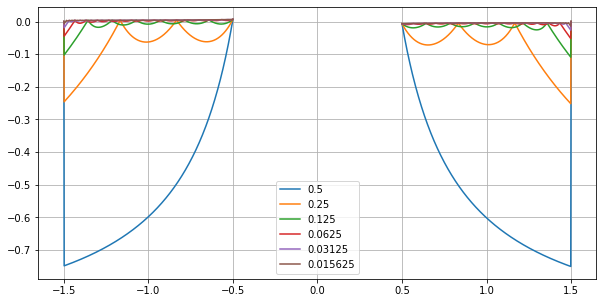

In [7]:
fig = plt.gcf()
fig.set_size_inches(10, 5)

error_norm = []

for idx, quantization in enumerate(tqdm(quantization_grid)):
    model = SpringRodsSystemSetup(
        **setup,
        step_size=quantization
    )
    solver = SpringRodsSystemSolver(model)
    solution = np.concatenate(solver())

    # err = solution - approximate_in_positions(reference_solution, reference_domain, curr_domain)
    solution_refined = approximate_in_positions(solution, np.concatenate(model.domain), reference_domain_concat)
    err = (solution_refined - reference_solution) / reference_solution
    err[0] = err[-1] = 0
    left_rod_err = err[:reference_domain[0].size]
    right_rod_err = err[reference_domain[0].size:]

    error_norm.append(l2_norm(values=(left_rod_err, right_rod_err), domain=reference_domain))

    plt.plot(reference_domain[0], left_rod_err, color=cmap(idx), label=f'{quantization_grid[idx]}')
    plt.plot(reference_domain[1], right_rod_err, color=cmap(idx))

plt.legend()

In [8]:
error_norm = np.array(error_norm)

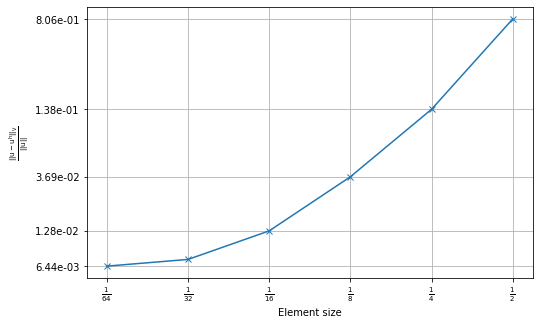

In [12]:
fig = plt.gcf()
fig.set_size_inches(8, 5)

plt.plot(quantization_grid, error_norm, marker='x')
plt.xlabel('Element size')
plt.ylabel(f'$\\frac{{||u - u^h||_V}}{{||u||}}$')
plt.xscale('log')
plt.yscale('log')
# plt.xticks(quantization_grid, [f'$\\frac{{1}}{{{q}}}$' for q in quantization_grid], fontsize=16)
# plt.xticks(quantization_grid, [f'${{{q}}}^{{-1}}$' for q in quantization_grid])
plt.xticks(quantization_grid, quantization_grid_labels)
yticks = np.delete(error_norm, -2)
plt.yticks(yticks, [f'{err:.2e}' for err in yticks])
plt.minorticks_off()